In [104]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd
#array and matrix data structures
import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 
#for median
import statistics

In [105]:
# Create the connection.
cnx = sqlite3.connect('data.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

turbine


In [106]:
#read sql
df = pd.read_sql_query("SELECT * FROM turbine", cnx)

In [107]:
#Split started column to two columns
df[['Date','Time']] = df.valuetime.str.split(" ",expand=True,)
df = df[['started','Date', 'Time', 'locname', 'plantno', 'power','wind']]

In [108]:
#change time format
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M:%S')
df

,started,Date,Time,locname,plantno,power,wind
0,2021-06-04 10:35:53.793993,2021-06-04,10:35:51,Ballincurry,1,698.0,8.700000
1,2021-06-04 10:35:53.793993,2021-06-04,10:35:52,Ballincurry,2,612.0,6.800000
2,2021-06-04 10:35:53.793993,2021-06-04,10:35:54,Ballincurry,1,704.0,8.300000
3,2021-06-04 10:35:53.793993,2021-06-04,10:35:55,Ballincurry,2,583.0,6.400000
4,2021-06-04 10:35:53.793993,2021-06-04,10:35:57,Ballincurry,1,716.0,8.500000
...,...,...,...,...,...,...,...
126220,2021-06-21 16:34:38.742056,2021-06-21,17:23:16,Ballincurry,1,1100.0,7.700000
126221,2021-06-21 16:34:38.742056,2021-06-21,17:23:17,Ballincurry,2,936.0,7.800000
126222,2021-06-21 16:34:38.742056,2021-06-21,17:23:19,Ballincurry,1,1065.0,8.300000
126223,2021-06-21 16:34:38.742056,2021-06-21,17:23:21,Ballincurry,2,958.0,8.400001


In [109]:
#create a df with hours 
df1=pd.date_range("00:00:00", "23:00:00", freq="60min").strftime('%H:%M:%S')

#another times
#df2=pd.date_range("00:00:02", "23:00:02", freq="60min").strftime('%H:%M:%S')
#df3=pd.date_range("00:00:59", "23:00:59", freq="60min").strftime('%H:%M:%S')
#df_time=df1.append(df2)
#df_time=df_time.append(df3)

print(df1)

Index(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00',
       '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00',
       '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
      dtype='object')


In [110]:
#keep only row with time format tt:00:00
#df_hourly=pd.DataFrame()
#for a in df1:
    #df_hourly = df_hourly.append(df.loc[df['Time'] == a])
#df_hourly.head(n=5)
df_hourly=df

#print df
df_hourly.head(10)

,started,Date,Time,locname,plantno,power,wind
0,2021-06-04 10:35:53.793993,2021-06-04,10:35:51,Ballincurry,1,698.0,8.7
1,2021-06-04 10:35:53.793993,2021-06-04,10:35:52,Ballincurry,2,612.0,6.8
2,2021-06-04 10:35:53.793993,2021-06-04,10:35:54,Ballincurry,1,704.0,8.3
3,2021-06-04 10:35:53.793993,2021-06-04,10:35:55,Ballincurry,2,583.0,6.4
4,2021-06-04 10:35:53.793993,2021-06-04,10:35:57,Ballincurry,1,716.0,8.5
5,2021-06-04 10:35:53.793993,2021-06-04,10:35:59,Ballincurry,2,553.0,7.3
6,2021-06-04 10:35:53.793993,2021-06-04,10:36:00,Ballincurry,1,748.0,9.0
7,2021-06-04 10:35:53.793993,2021-06-04,10:36:02,Ballincurry,2,529.0,6.9
8,2021-06-04 10:35:53.793993,2021-06-04,10:36:04,Ballincurry,1,778.0,9.3
9,2021-06-04 10:35:53.793993,2021-06-04,10:36:05,Ballincurry,2,528.0,7.1


In [111]:
#separe date time columns
df_hourly["DateTime"] = df_hourly["Date"] + " " + df_hourly["Time"]

#order ascending by wind to apply interpolation
df_hourly=df_hourly.sort_values(by=['wind'], axis=0, ascending=True)

#positive values for power
df_hourly=df_hourly[(df_hourly.power > 0.0)&(df_hourly.wind > 0.0)]

#print first 15 rows
df_hourly.head(n=15)


,started,Date,Time,locname,plantno,power,wind,DateTime
23147,2021-06-06 08:34:51.722051,2021-06-06,14:34:38,Ballincurry,1,4.0,1.3,2021-06-06 14:34:38
111081,2021-06-16 10:52:29.278947,2021-06-16,16:10:57,Ballincurry,1,28.0,1.3,2021-06-16 16:10:57
112025,2021-06-16 10:52:29.278947,2021-06-16,16:36:16,Ballincurry,1,11.0,1.3,2021-06-16 16:36:16
119133,2021-06-16 10:52:29.278947,2021-06-17,11:24:49,Ballincurry,2,29.0,1.4,2021-06-17 11:24:49
10755,2021-06-06 08:34:51.722051,2021-06-06,09:13:17,Ballincurry,2,3.0,1.4,2021-06-06 09:13:17
23372,2021-06-06 08:34:51.722051,2021-06-06,14:40:30,Ballincurry,2,24.0,1.4,2021-06-06 14:40:30
111079,2021-06-16 10:52:29.278947,2021-06-16,16:10:54,Ballincurry,1,32.0,1.4,2021-06-16 16:10:54
23374,2021-06-06 08:34:51.722051,2021-06-06,14:40:33,Ballincurry,2,16.0,1.4,2021-06-06 14:40:33
110958,2021-06-16 10:52:29.278947,2021-06-16,16:07:40,Ballincurry,2,16.0,1.4,2021-06-16 16:07:40
110997,2021-06-16 10:52:29.278947,2021-06-16,16:08:42,Ballincurry,1,7.0,1.4,2021-06-16 16:08:42


In [112]:
#separe by plant no
df_hourly_1=df_hourly[(df_hourly.plantno == 1)]
df_hourly_1

,started,Date,Time,locname,plantno,power,wind,DateTime
23147,2021-06-06 08:34:51.722051,2021-06-06,14:34:38,Ballincurry,1,4.0,1.3,2021-06-06 14:34:38
111081,2021-06-16 10:52:29.278947,2021-06-16,16:10:57,Ballincurry,1,28.0,1.3,2021-06-16 16:10:57
112025,2021-06-16 10:52:29.278947,2021-06-16,16:36:16,Ballincurry,1,11.0,1.3,2021-06-16 16:36:16
111079,2021-06-16 10:52:29.278947,2021-06-16,16:10:54,Ballincurry,1,32.0,1.4,2021-06-16 16:10:54
110997,2021-06-16 10:52:29.278947,2021-06-16,16:08:42,Ballincurry,1,7.0,1.4,2021-06-16 16:08:42
...,...,...,...,...,...,...,...,...
82579,2021-06-09 12:53:55.145600,2021-06-10,14:20:10,Ballincurry,1,2366.0,15.1,2021-06-10 14:20:10
81517,2021-06-09 12:53:55.145600,2021-06-10,13:52:22,Ballincurry,1,2371.0,15.1,2021-06-10 13:52:22
81981,2021-06-09 12:53:55.145600,2021-06-10,14:04:29,Ballincurry,1,2393.0,15.1,2021-06-10 14:04:29
81515,2021-06-09 12:53:55.145600,2021-06-10,13:52:19,Ballincurry,1,2380.0,15.3,2021-06-10 13:52:19


In [113]:
df_hourly_2=df_hourly[(df_hourly.plantno == 2)]
df_hourly_2

,started,Date,Time,locname,plantno,power,wind,DateTime
119133,2021-06-16 10:52:29.278947,2021-06-17,11:24:49,Ballincurry,2,29.0,1.400000,2021-06-17 11:24:49
10755,2021-06-06 08:34:51.722051,2021-06-06,09:13:17,Ballincurry,2,3.0,1.400000,2021-06-06 09:13:17
23372,2021-06-06 08:34:51.722051,2021-06-06,14:40:30,Ballincurry,2,24.0,1.400000,2021-06-06 14:40:30
23374,2021-06-06 08:34:51.722051,2021-06-06,14:40:33,Ballincurry,2,16.0,1.400000,2021-06-06 14:40:33
110958,2021-06-16 10:52:29.278947,2021-06-16,16:07:40,Ballincurry,2,16.0,1.400000,2021-06-16 16:07:40
...,...,...,...,...,...,...,...,...
82542,2021-06-09 12:53:55.145600,2021-06-10,14:19:10,Ballincurry,2,2365.0,14.200000,2021-06-10 14:19:10
81884,2021-06-09 12:53:55.145600,2021-06-10,14:01:57,Ballincurry,2,2364.0,14.300000,2021-06-10 14:01:57
82186,2021-06-09 12:53:55.145600,2021-06-10,14:09:51,Ballincurry,2,2377.0,14.700000,2021-06-10 14:09:51
82188,2021-06-09 12:53:55.145600,2021-06-10,14:09:54,Ballincurry,2,2355.0,14.900001,2021-06-10 14:09:54


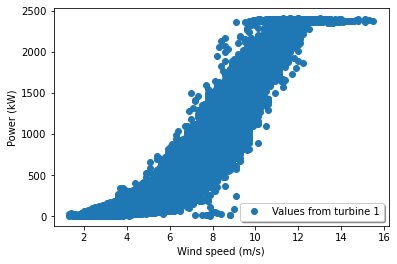

In [143]:
fig, ax = plt.subplots()

ax.plot(df_hourly_1["wind"], df_hourly_1["power"],"o",label='Values from turbine 1')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

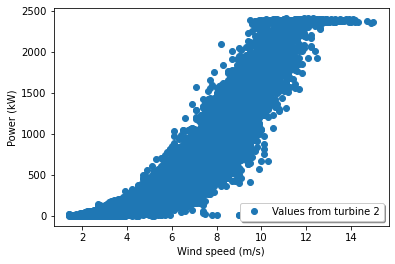

In [144]:
fig, ax = plt.subplots()

ax.plot(df_hourly_2["wind"], df_hourly_2["power"],"o",label='Values from turbine 2')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Anomalies

In [117]:
df_hourly_1[(df_hourly_1.wind == 1.9)]

,started,Date,Time,locname,plantno,power,wind,DateTime
11010,2021-06-06 08:34:51.722051,2021-06-06,09:19:59,Ballincurry,1,13.0,1.9,2021-06-06 09:19:59
11780,2021-06-06 08:34:51.722051,2021-06-06,09:39:54,Ballincurry,1,3.0,1.9,2021-06-06 09:39:54
10852,2021-06-06 08:34:51.722051,2021-06-06,09:15:51,Ballincurry,1,11.0,1.9,2021-06-06 09:15:51
10816,2021-06-06 08:34:51.722051,2021-06-06,09:14:55,Ballincurry,1,10.0,1.9,2021-06-06 09:14:55
10876,2021-06-06 08:34:51.722051,2021-06-06,09:16:27,Ballincurry,1,7.0,1.9,2021-06-06 09:16:27
...,...,...,...,...,...,...,...,...
25135,2021-06-06 08:34:51.722051,2021-06-06,15:27:15,Ballincurry,1,2.0,1.9,2021-06-06 15:27:15
110973,2021-06-16 10:52:29.278947,2021-06-16,16:08:05,Ballincurry,1,5.0,1.9,2021-06-16 16:08:05
105831,2021-06-16 10:52:29.278947,2021-06-16,13:50:54,Ballincurry,1,33.0,1.9,2021-06-16 13:50:54
110975,2021-06-16 10:52:29.278947,2021-06-16,16:08:08,Ballincurry,1,4.0,1.9,2021-06-16 16:08:08


In [118]:
df_hourly_1[(df_hourly_1.wind == 3.5)]

,started,Date,Time,locname,plantno,power,wind,DateTime
108051,2021-06-16 10:52:29.278947,2021-06-16,14:50:04,Ballincurry,1,141.0,3.5,2021-06-16 14:50:04
30480,2021-06-06 17:11:54.754563,2021-06-06,17:46:18,Ballincurry,1,17.0,3.5,2021-06-06 17:46:18
34654,2021-06-06 17:11:54.754563,2021-06-06,19:35:15,Ballincurry,1,80.0,3.5,2021-06-06 19:35:15
107639,2021-06-16 10:52:29.278947,2021-06-16,14:39:05,Ballincurry,1,77.0,3.5,2021-06-16 14:39:05
32070,2021-06-06 17:11:54.754563,2021-06-06,18:28:35,Ballincurry,1,39.0,3.5,2021-06-06 18:28:35
...,...,...,...,...,...,...,...,...
26045,2021-06-06 08:34:51.722051,2021-06-06,15:50:36,Ballincurry,1,59.0,3.5,2021-06-06 15:50:36
23221,2021-06-06 08:34:51.722051,2021-06-06,14:36:34,Ballincurry,1,39.0,3.5,2021-06-06 14:36:34
38418,2021-06-06 17:11:54.754563,2021-06-06,21:12:19,Ballincurry,1,49.0,3.5,2021-06-06 21:12:19
27551,2021-06-06 08:34:51.722051,2021-06-06,16:29:23,Ballincurry,1,81.0,3.5,2021-06-06 16:29:23


In [119]:
df_hourly_2[(df_hourly_2.wind == 1.4)]

,started,Date,Time,locname,plantno,power,wind,DateTime
119133,2021-06-16 10:52:29.278947,2021-06-17,11:24:49,Ballincurry,2,29.0,1.4,2021-06-17 11:24:49
10755,2021-06-06 08:34:51.722051,2021-06-06,09:13:17,Ballincurry,2,3.0,1.4,2021-06-06 09:13:17
23372,2021-06-06 08:34:51.722051,2021-06-06,14:40:30,Ballincurry,2,24.0,1.4,2021-06-06 14:40:30
23374,2021-06-06 08:34:51.722051,2021-06-06,14:40:33,Ballincurry,2,16.0,1.4,2021-06-06 14:40:33
110958,2021-06-16 10:52:29.278947,2021-06-16,16:07:40,Ballincurry,2,16.0,1.4,2021-06-16 16:07:40


## Clean the dataset

### Turbine 1

In [120]:
#empthy df
df_1 = pd.DataFrame()

#group by wind and calculate the median power
df_1['Median_power'] = df_hourly_1.groupby('wind')['power'].transform('median')

#append new median power values to df
df_hourly_1 = pd.concat([df_hourly_1, df_1], axis=1, join="inner")

#store df
%store df_hourly_1

df_hourly_1

Stored 'df_hourly_1' (DataFrame)


,started,Date,Time,locname,plantno,power,wind,DateTime,Median_power
23147,2021-06-06 08:34:51.722051,2021-06-06,14:34:38,Ballincurry,1,4.0,1.3,2021-06-06 14:34:38,11.0
111081,2021-06-16 10:52:29.278947,2021-06-16,16:10:57,Ballincurry,1,28.0,1.3,2021-06-16 16:10:57,11.0
112025,2021-06-16 10:52:29.278947,2021-06-16,16:36:16,Ballincurry,1,11.0,1.3,2021-06-16 16:36:16,11.0
111079,2021-06-16 10:52:29.278947,2021-06-16,16:10:54,Ballincurry,1,32.0,1.4,2021-06-16 16:10:54,19.5
110997,2021-06-16 10:52:29.278947,2021-06-16,16:08:42,Ballincurry,1,7.0,1.4,2021-06-16 16:08:42,19.5
...,...,...,...,...,...,...,...,...,...
82579,2021-06-09 12:53:55.145600,2021-06-10,14:20:10,Ballincurry,1,2366.0,15.1,2021-06-10 14:20:10,2371.0
81517,2021-06-09 12:53:55.145600,2021-06-10,13:52:22,Ballincurry,1,2371.0,15.1,2021-06-10 13:52:22,2371.0
81981,2021-06-09 12:53:55.145600,2021-06-10,14:04:29,Ballincurry,1,2393.0,15.1,2021-06-10 14:04:29,2371.0
81515,2021-06-09 12:53:55.145600,2021-06-10,13:52:19,Ballincurry,1,2380.0,15.3,2021-06-10 13:52:19,2380.0


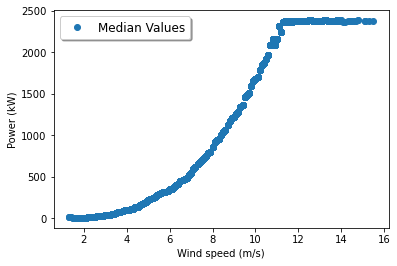

In [132]:

fig, ax = plt.subplots()
ax.plot(df_hourly_1["wind"], df_hourly_1["Median_power"],"o",label='Median Values')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()



### Turbine 2

In [122]:
#empthy df
df_2 = pd.DataFrame()

#group by wind and calculate the median power
df_2['Median_power'] = df_hourly_2.groupby('wind')['power'].transform('median')

#append new median power values to df
df_hourly_2 = pd.concat([df_hourly_2, df_2], axis=1, join="inner")

#store df
%store df_hourly_2

df_hourly_2

Stored 'df_hourly_2' (DataFrame)


,started,Date,Time,locname,plantno,power,wind,DateTime,Median_power
119133,2021-06-16 10:52:29.278947,2021-06-17,11:24:49,Ballincurry,2,29.0,1.400000,2021-06-17 11:24:49,16.0
10755,2021-06-06 08:34:51.722051,2021-06-06,09:13:17,Ballincurry,2,3.0,1.400000,2021-06-06 09:13:17,16.0
23372,2021-06-06 08:34:51.722051,2021-06-06,14:40:30,Ballincurry,2,24.0,1.400000,2021-06-06 14:40:30,16.0
23374,2021-06-06 08:34:51.722051,2021-06-06,14:40:33,Ballincurry,2,16.0,1.400000,2021-06-06 14:40:33,16.0
110958,2021-06-16 10:52:29.278947,2021-06-16,16:07:40,Ballincurry,2,16.0,1.400000,2021-06-16 16:07:40,16.0
...,...,...,...,...,...,...,...,...,...
82542,2021-06-09 12:53:55.145600,2021-06-10,14:19:10,Ballincurry,2,2365.0,14.200000,2021-06-10 14:19:10,2378.0
81884,2021-06-09 12:53:55.145600,2021-06-10,14:01:57,Ballincurry,2,2364.0,14.300000,2021-06-10 14:01:57,2364.0
82186,2021-06-09 12:53:55.145600,2021-06-10,14:09:51,Ballincurry,2,2377.0,14.700000,2021-06-10 14:09:51,2377.0
82188,2021-06-09 12:53:55.145600,2021-06-10,14:09:54,Ballincurry,2,2355.0,14.900001,2021-06-10 14:09:54,2355.0


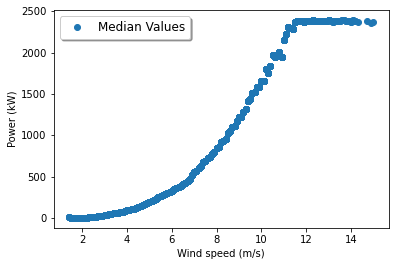

In [133]:
fig, ax = plt.subplots()

ax.plot(df_hourly_2["wind"], df_hourly_2["Median_power"],"o",label='Median Values')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()